In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from src.clustering.clusterer_config import perform_clusterer_search_from_config, ClustererConfig

In [2]:
COLORS = ["red", "green", "blue", "yellow", "orange", "purple"]

# Reading the data

For better clustering exploration I will merge the two labeled data files we currently have and merge them into a 2d series.

Since we cannot meaningfully merge two entries from different repeated experiments, I will use average VALUE of a given compound in an experiment as one dimension.

In [3]:
data_ros1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ros2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")

In [4]:
data_ros1["id"] = (data_ros1["DTT  - compound ID"].astype(str) + data_ros1["Barcode assay plate"].str[:-4]) + data_ros1["Barcode assay plate"].str[-1]
data_ros1.head()

,DTT - compound ID,Barcode assay plate,WELL,row,column,VALUE,Well type,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),...,CMPD Mean(VALUE),CMPD Standard deviation(VALUE),Z',Z' robust,% ACTIVATION,Z score,ACTIVITY (above 30%),ACTIVITY (Z score above 3),Transfer Status,id
0,102092,B1007L2002L03DTT2,P22,16,22,27290,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-0.808767,-0.230132,INACTIVE,Z score below 3,OK,102092B1007L2002L032
1,102091,B1007L2002L03DTT2,N22,14,22,26992,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-1.031746,-0.256899,INACTIVE,Z score below 3,OK,102091B1007L2002L032
2,102090,B1007L2002L03DTT2,L22,12,22,27213,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-0.866382,-0.237048,INACTIVE,Z score below 3,OK,102090B1007L2002L032
3,102089,B1007L2002L03DTT2,J22,10,22,48548,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,15.097574,1.679343,INACTIVE,Z score below 3,OK,102089B1007L2002L032
4,102088,B1007L2002L03DTT2,H22,8,22,28456,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,0.063695,-0.125397,INACTIVE,Z score below 3,OK,102088B1007L2002L032


In [5]:
data_ros2["id"] = (data_ros2["HRP - compound ID"].astype(str) + data_ros2["Barcode assay plate"].str[:-4]) + data_ros2["Barcode assay plate"].str[-1]
data_ros2.head()

,HRP - compound ID,Barcode assay plate,WELL,row,column,VALUE,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),CTRL NEG Median(VALUE),CTRL POS Mean(VALUE),CTRL POS Standard deviation(VALUE),CTRL POS Median(VALUE),Z',Z' robust,% ACTIVATION,ACTIVITY,Destination Plate Barcode,Transfer Status,id
0,102092,B1007L2002L03HRP1,P22,16,22,0.104,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.639877,INACTIVE,NaN,OK,102092B1007L2002L031
1,102092,B1007L2002L03HRP2,P22,16,22,0.105,NaN,0.102563,0.002279,0.1025,0.589063,0.016126,0.591,0.886500,0.886965,0.501028,INACTIVE,NaN,OK,102092B1007L2002L032
2,102091,B1007L2002L03HRP1,N22,14,22,0.102,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.230356,INACTIVE,NaN,OK,102091B1007L2002L031
3,102091,B1007L2002L03HRP2,N22,14,22,0.111,NaN,0.102563,0.002279,0.1025,0.589063,0.016126,0.591,0.886500,0.886965,1.734327,INACTIVE,NaN,OK,102091B1007L2002L032
4,102090,B1007L2002L03HRP1,L22,12,22,0.102,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.230356,INACTIVE,NaN,OK,102090B1007L2002L031


In [6]:
combined_df = pd.merge(data_ros1, data_ros2, on="id")
combined_df.head()

,DTT - compound ID,Barcode assay plate_x,WELL_x,row_x,column_x,VALUE_x,Well type,CONTROL OUTLIER_x,CTRL NEG Mean(VALUE)_x,CTRL NEG Standard deviation(VALUE)_x,...,CTRL NEG Median(VALUE)_y,CTRL POS Mean(VALUE)_y,CTRL POS Standard deviation(VALUE)_y,CTRL POS Median(VALUE)_y,Z'_y,Z' robust_y,% ACTIVATION_y,ACTIVITY,Destination Plate Barcode,Transfer Status_y
0,102092,B1007L2002L03DTT2,P22,16,22,27290,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.501028,INACTIVE,NaN,OK
1,102091,B1007L2002L03DTT2,N22,14,22,26992,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,1.734327,INACTIVE,NaN,OK
2,102090,B1007L2002L03DTT2,L22,12,22,27213,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.295478,INACTIVE,NaN,OK
3,102089,B1007L2002L03DTT2,J22,10,22,48548,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.706578,INACTIVE,NaN,OK
4,102088,B1007L2002L03DTT2,H22,8,22,28456,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.295478,INACTIVE,NaN,OK


In [7]:
combined_df.rename(columns={"VALUE_x" : "VALUE_DTT", "VALUE_y" : "VALUE_HRP", "% ACTIVATION_x": "ACTIVITY_DTT_PERC", "% ACTIVATION_y":"ACTIVITY_HRP_PERC"}, inplace=True)
combined_df = combined_df[["id", "VALUE_DTT", "VALUE_HRP", "ACTIVITY_DTT_PERC", "ACTIVITY_HRP_PERC"]]

In [8]:
qt_dtt = QuantileTransformer(random_state=34)
qt_hrp = QuantileTransformer(random_state=34)

quart_perc_ros1 = qt_dtt.fit_transform(combined_df["ACTIVITY_DTT_PERC"].to_numpy().reshape(-1, 1)).flatten()
quer_perc_ros2 = qt_hrp.fit_transform(combined_df["ACTIVITY_HRP_PERC"].to_numpy().reshape(-1, 1)).flatten()
combined_df["DTT_ACTIVITY_PERC_Q"] = quart_perc_ros1
combined_df["HRP_ACTIVITY_PERC_Q"] = quer_perc_ros2
value_series = combined_df[["DTT_ACTIVITY_PERC_Q", "HRP_ACTIVITY_PERC_Q"]].to_numpy()

# Data Clustering Parameters Setup

I will use GeneralClustererFinder on the following algorithms:
-   KMeans
-   GaussianMixture
-   AgglomerativeClustering
-   DBSCAN

In [9]:
RANDOM_STATE = 31
CLUSTERING_CONFIG = {
    "KMeans": ClustererConfig(KMeans(), ParameterGrid({
        "n_clusters": range(2, 16),
        "random_state": [RANDOM_STATE]
    })),
    "GaussianMixture": ClustererConfig(GaussianMixture(), ParameterGrid({
        "n_components": range(2, 16),
        "random_state": [RANDOM_STATE]
    })),
    "AgglomerativeClustering": ClustererConfig(AgglomerativeClustering(), ParameterGrid({
        "linkage": ["ward", "average"],
    })),
    "DBSCAN": ClustererConfig(DBSCAN(), ParameterGrid({
        "eps": np.arange(0.1, 1.0, 0.1) / 10,
        "min_samples": [5, 6, 7, 8, 9, 10],
    }))
}

In [10]:
def summarize_clustering(values: np.ndarray, labels: np.ndarray) -> None:
    all_labels = np.unique(labels).flatten()
    for label in all_labels:
        label_values = values[labels.flatten() == label]
        print(f"Cluster {label}: {len(label_values)} values")
        print(f"\tMean: {np.mean(label_values, axis=0)}")
        print(f"\tStd: {np.std(label_values, axis=0)}")
        print(f"\tMin: {np.min(label_values, axis=0)}")
        print(f"\tMax: {np.max(label_values, axis=0)}")
        print()


## Clustering results using Silhouette Score

In [11]:
def protective_silhouette_metric(values: np.ndarray, labels: np.ndarray) -> float:
    if len(np.unique(labels)) == 1:
        return -np.inf
    return metrics.silhouette_score(values, labels)

    
ss_results = perform_clusterer_search_from_config(value_series, protective_silhouette_metric, combined_df.index, CLUSTERING_CONFIG)

==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: 0.3545954410129238
Params: {'n_clusters': 3, 'random_state': 31} | Score: 0.37954850888362995
Params: {'n_clusters': 4, 'random_state': 31} | Score: 0.40948447182650455
Params: {'n_clusters': 5, 'random_state': 31} | Score: 0.386417128019048
Params: {'n_clusters': 6, 'random_state': 31} | Score: 0.37807388560957206
Params: {'n_clusters': 7, 'random_state': 31} | Score: 0.35615346436825657
Params: {'n_clusters': 8, 'random_state': 31} | Score: 0.3693549530117801
Params: {'n_clusters': 9, 'random_state': 31} | Score: 0.3680577562675588
Params: {'n_clusters': 10, 'random_state': 31} | Score: 0.3724191987551778
Params: {'n_clusters': 11, 'random_state': 31} | Score: 0.37519988182296327
Params: {'n_clusters': 12, 'random_state': 31} | Score: 0.38220663990795845
Params: {'n_clusters': 13, 'random_state': 31} | Score: 0.36450059215756997
Params: {'n_clusters': 14, 'random_state': 31} | Score: 0.36706390379

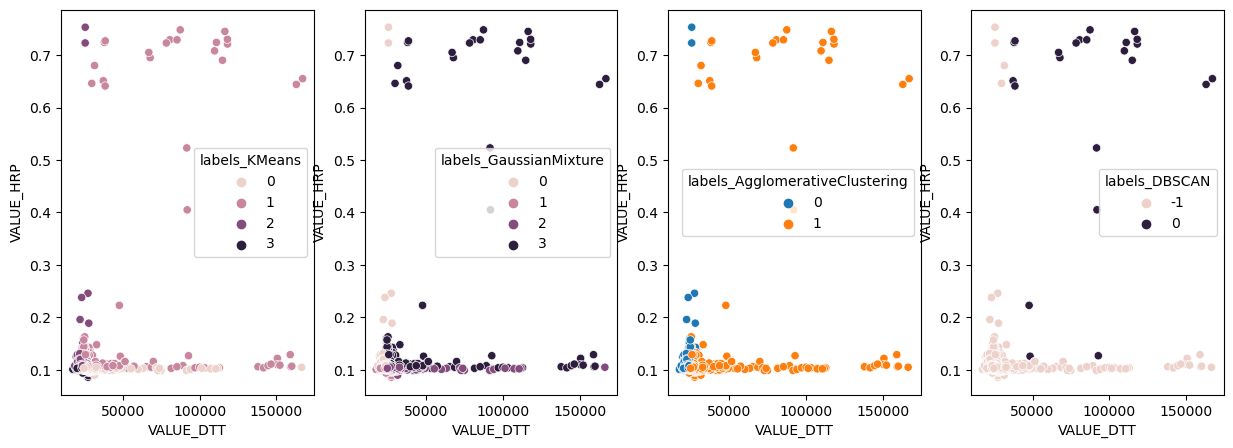

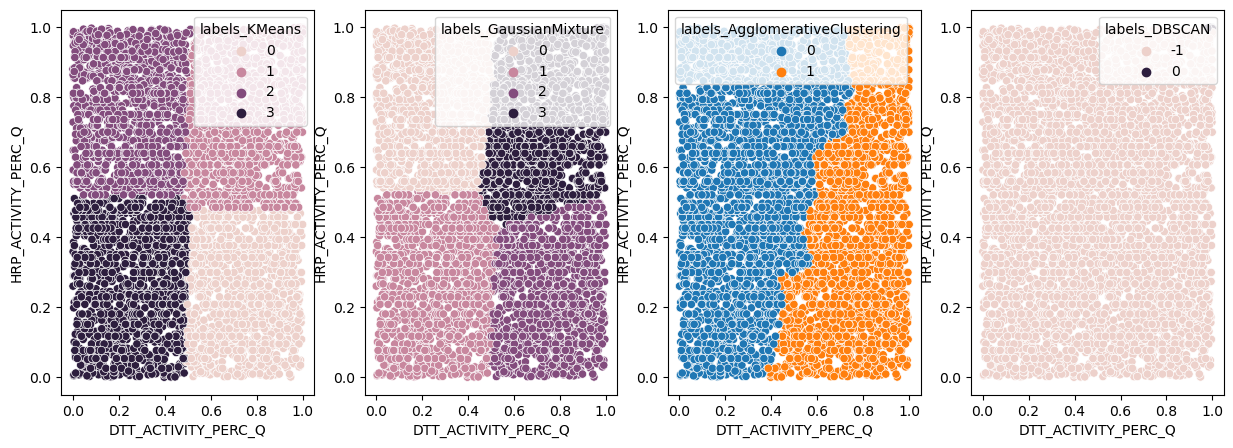

In [12]:
ss_scores_merged = pd.concat([combined_df, ss_results], axis=1)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for algorithm, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{algorithm}", ax=subplt)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for algorithm, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="DTT_ACTIVITY_PERC_Q", y="HRP_ACTIVITY_PERC_Q", hue=f"labels_{algorithm}", ax=subplt)

C:\Users\sbart\AppData\Local\Temp\ipykernel_27812\2428600363.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  kmeans_grouped = ss_scores_merged.groupby("labels_KMeans").mean()


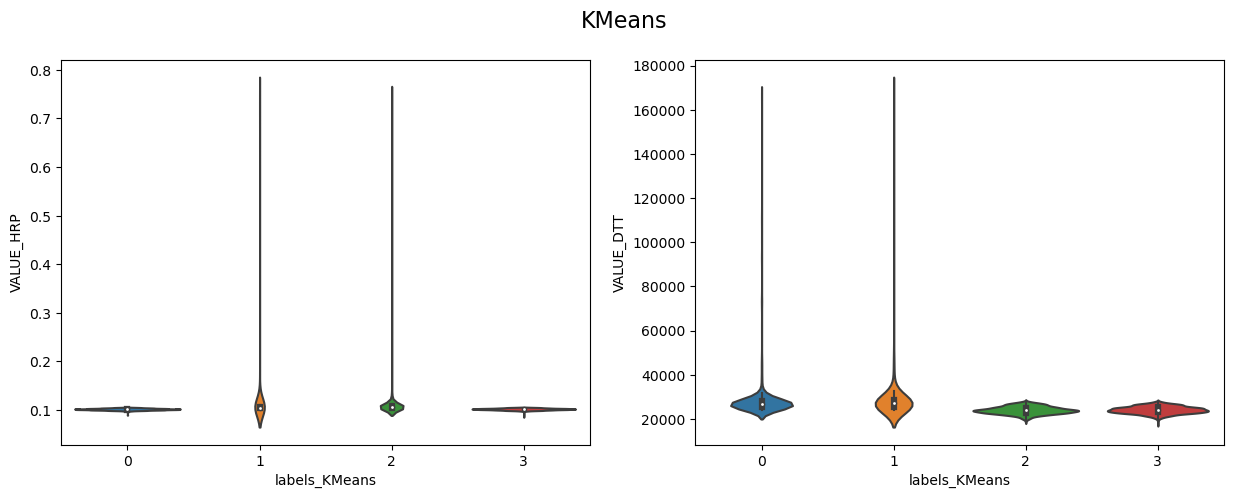

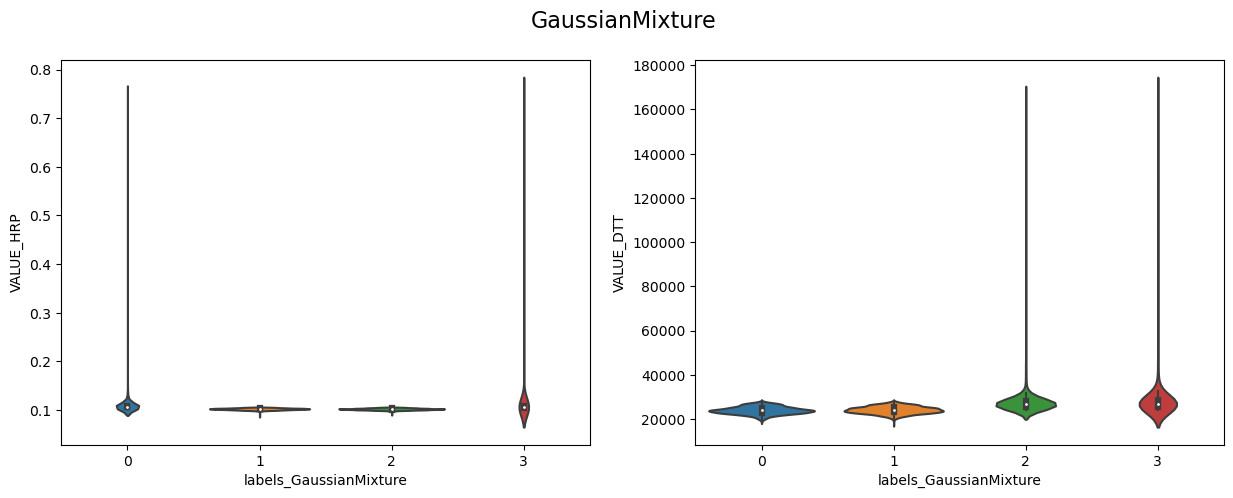

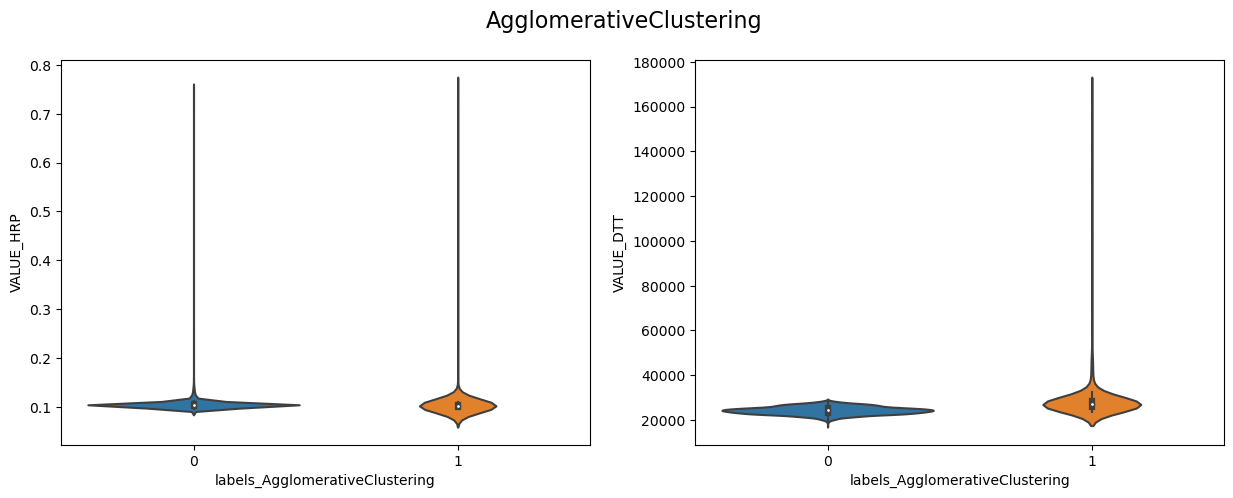

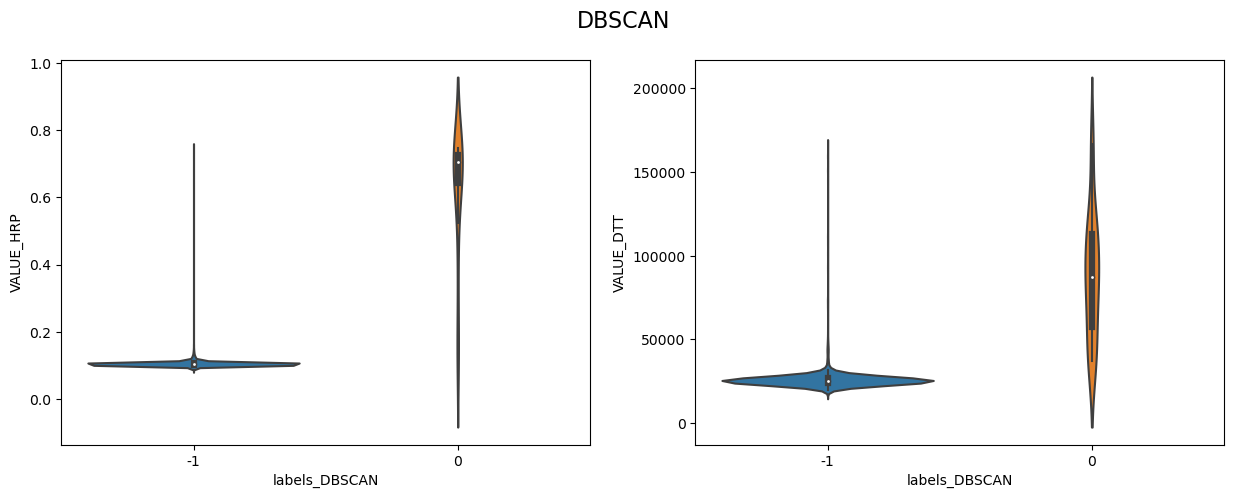

In [13]:
kmeans_grouped = ss_scores_merged.groupby("labels_KMeans").mean()
for algorithm in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(ss_scores_merged, x="labels_"+algorithm, y="VALUE_HRP", ax=ax[0])
    sns.violinplot(ss_scores_merged, x="labels_"+algorithm, y="VALUE_DTT", ax=ax[1])
    fig.suptitle(algorithm, fontsize=16)

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


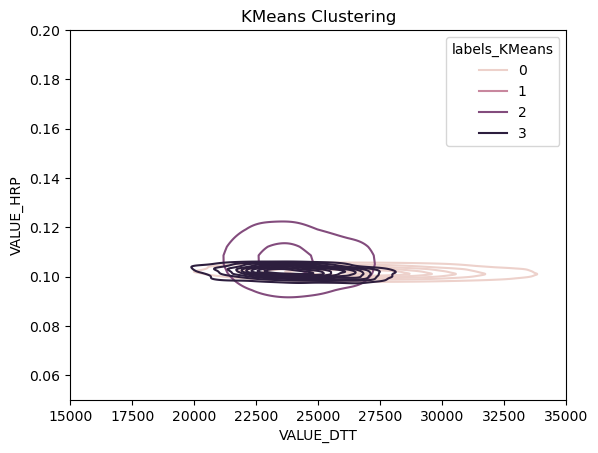

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


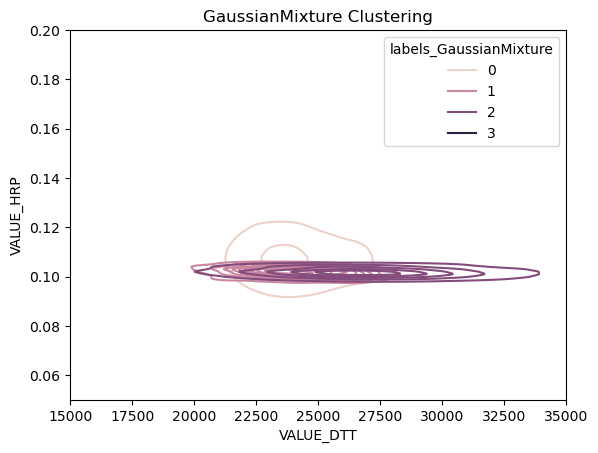

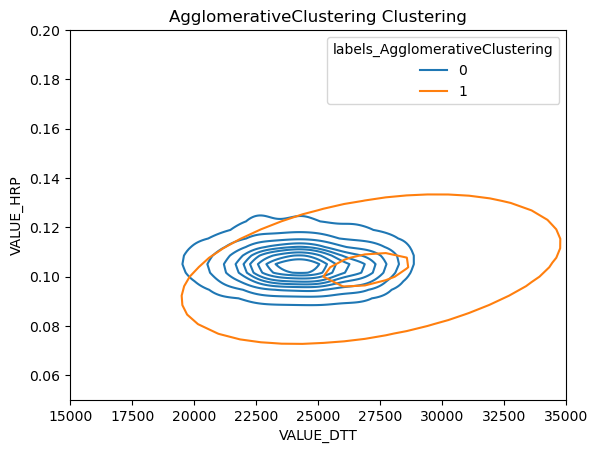

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


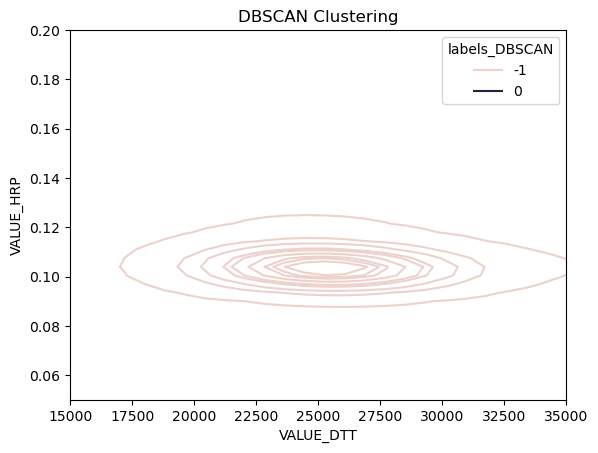

In [14]:
for algorithm in CLUSTERING_CONFIG:
    sns.kdeplot(ss_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{algorithm}")
    plt.xlim(15_000, 35_000)
    plt.ylim(0.05, 0.2)
    plt.title(f"{algorithm} Clustering")
    plt.show()

## Clustering results using Davies-Bouldin score

In [15]:
def protective_negated_davies_bouldin(values: np.ndarray, labels: np.ndarray) -> float:
    if len(np.unique(labels)) == 1:
        return -np.inf
    return -metrics.davies_bouldin_score(values, labels)

db_results = perform_clusterer_search_from_config(value_series, protective_negated_davies_bouldin, combined_df.index, CLUSTERING_CONFIG)

==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: -1.1787565000651223
Params: {'n_clusters': 3, 'random_state': 31} | Score: -0.8626399072509319
Params: {'n_clusters': 4, 'random_state': 31} | Score: -0.7677318885102
Params: {'n_clusters': 5, 'random_state': 31} | Score: -0.8751049273991839
Params: {'n_clusters': 6, 'random_state': 31} | Score: -0.8521295770527878
Params: {'n_clusters': 7, 'random_state': 31} | Score: -0.9063489272499873
Params: {'n_clusters': 8, 'random_state': 31} | Score: -0.7930036134818619
Params: {'n_clusters': 9, 'random_state': 31} | Score: -0.7719960437357921
Params: {'n_clusters': 10, 'random_state': 31} | Score: -0.8007004298566344
Params: {'n_clusters': 11, 'random_state': 31} | Score: -0.7946744541195724
Params: {'n_clusters': 12, 'random_state': 31} | Score: -0.7578691021566768
Params: {'n_clusters': 13, 'random_state': 31} | Score: -0.7954413876783549
Params: {'n_clusters': 14, 'random_state': 31} | Score: -0.7765312

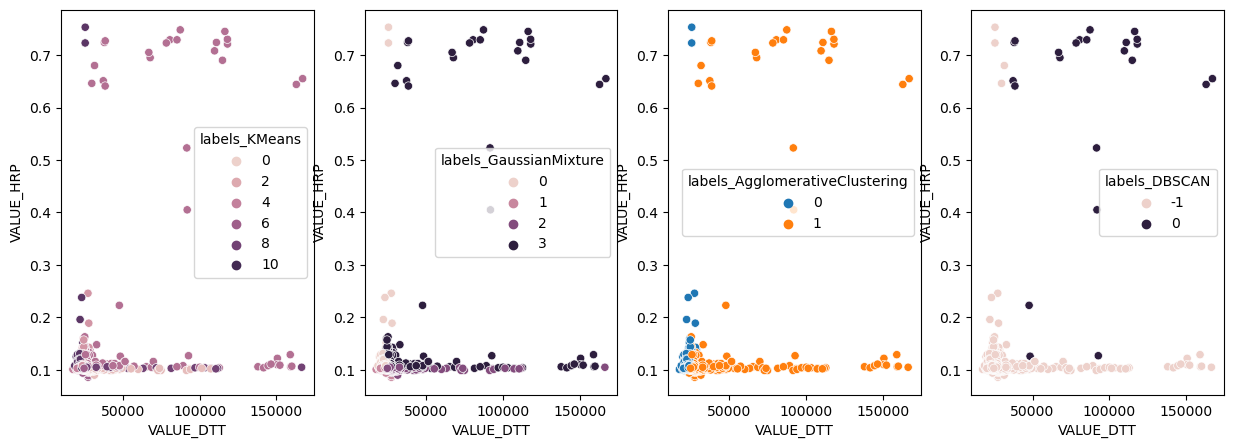

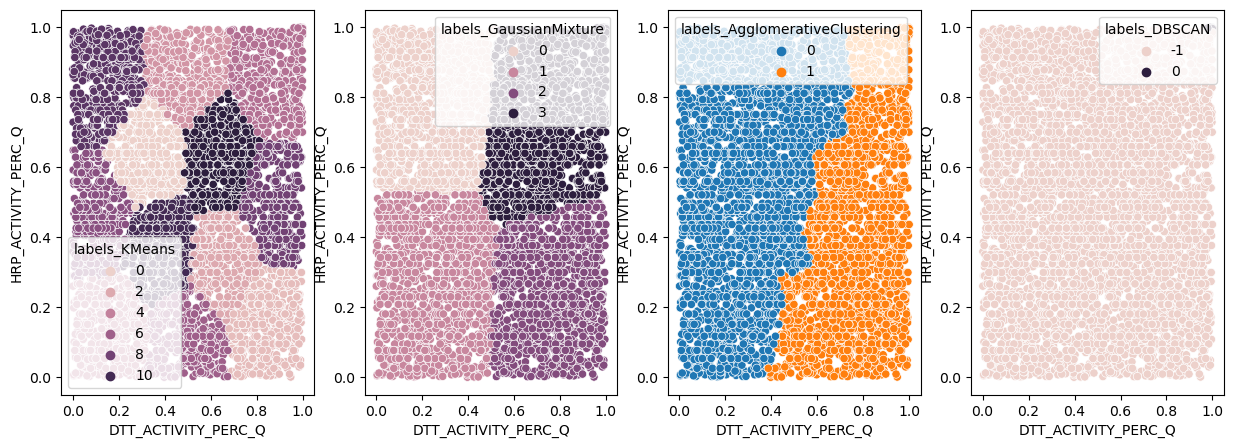

In [16]:
db_scores_merged = pd.concat([combined_df, db_results], axis=1)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for algorithm, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{algorithm}", ax=subplt)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for algorithm, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="DTT_ACTIVITY_PERC_Q", y="HRP_ACTIVITY_PERC_Q", hue=f"labels_{algorithm}", ax=subplt)

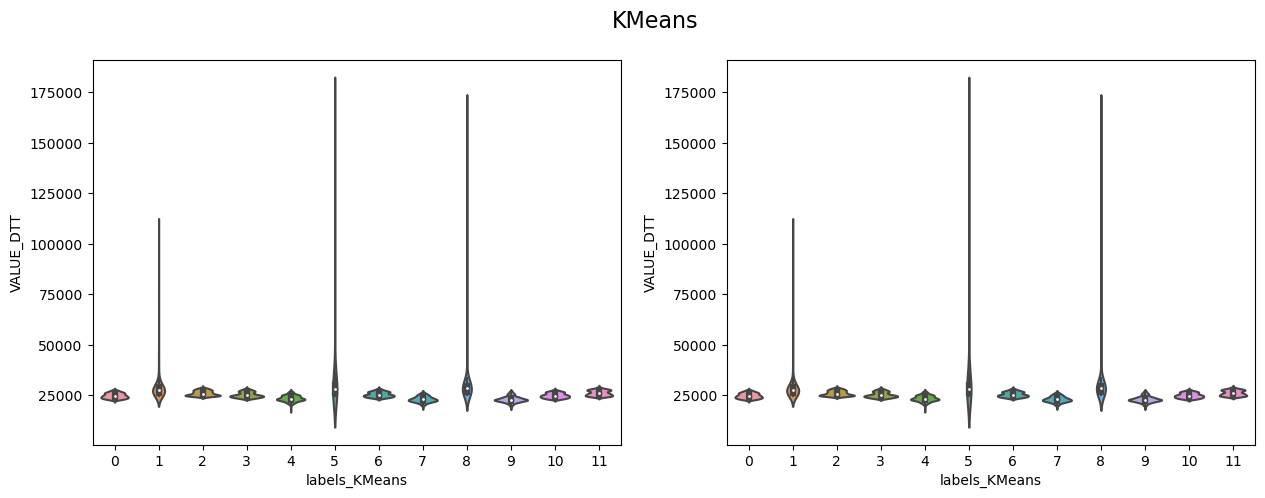

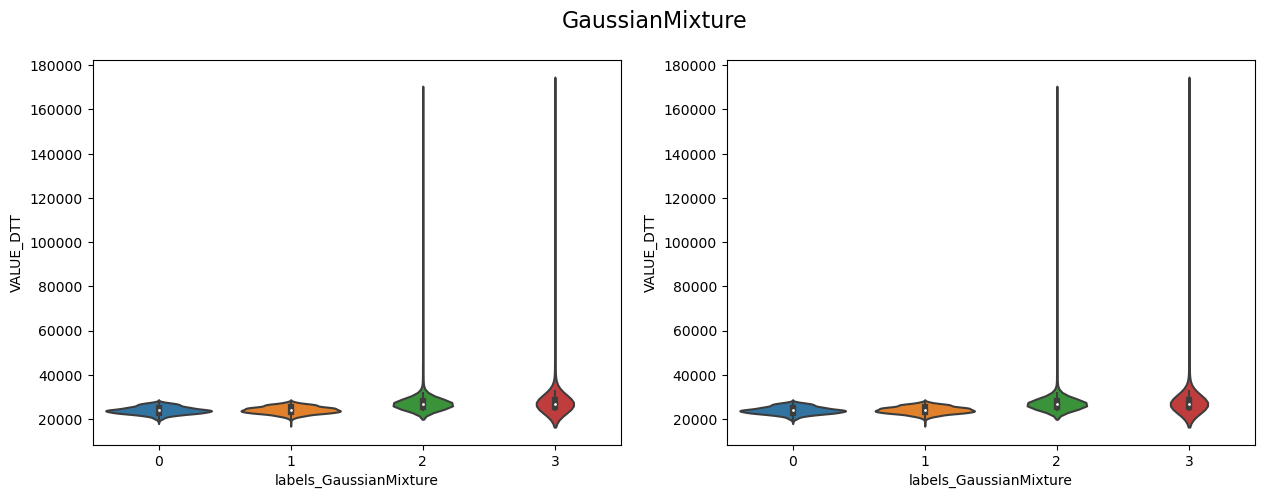

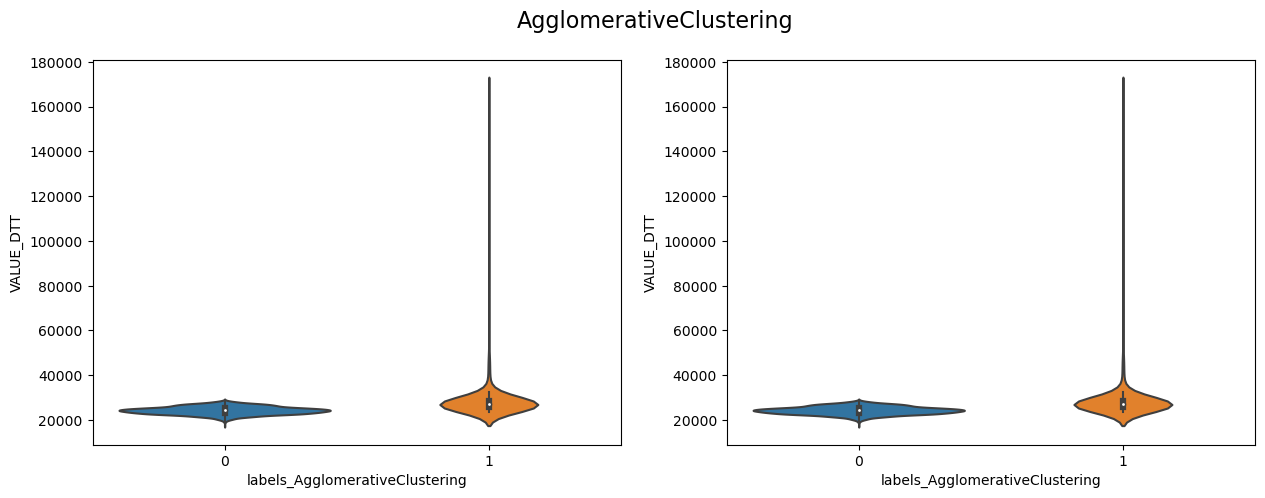

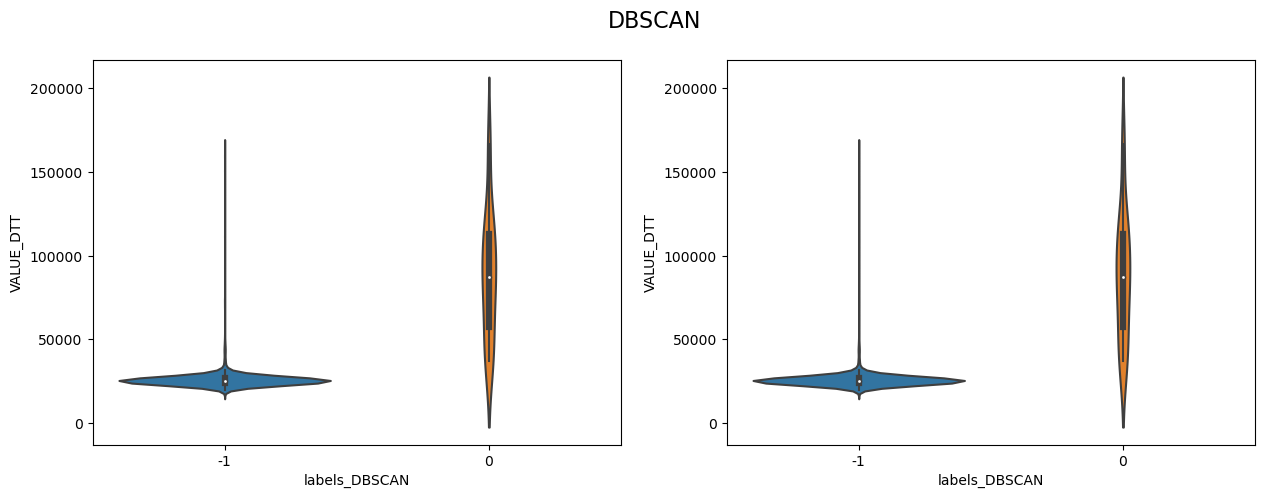

In [17]:
for algorithm in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(db_scores_merged, x="labels_"+algorithm, y="VALUE_DTT", ax=ax[0])
    sns.violinplot(db_scores_merged, x="labels_"+algorithm, y="VALUE_DTT", ax=ax[1])
    fig.suptitle(algorithm, fontsize=16)

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


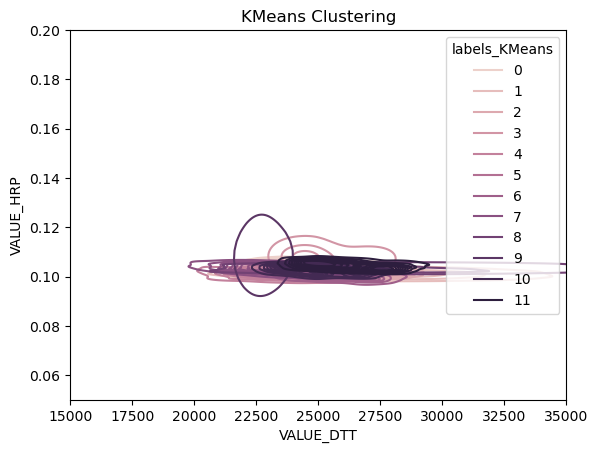

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


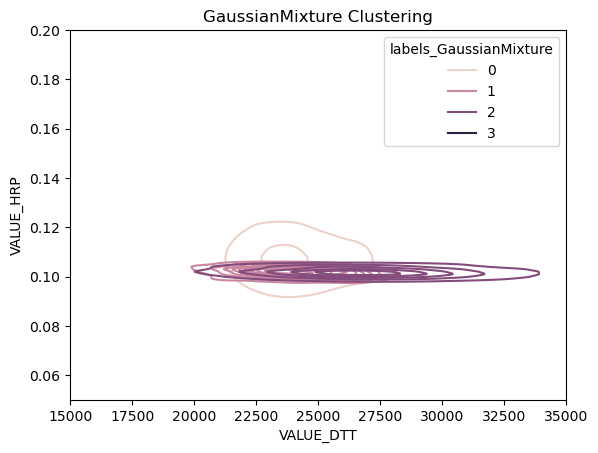

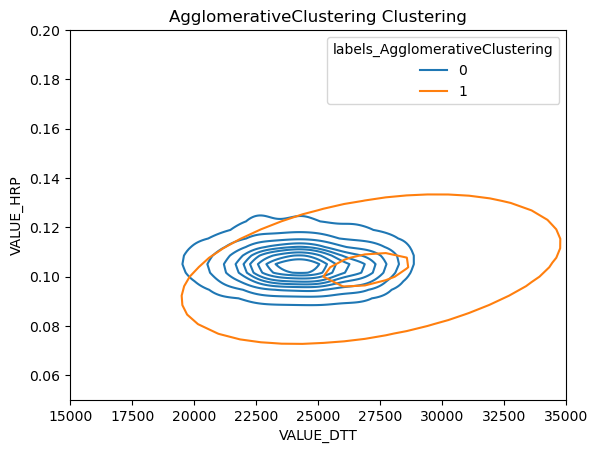

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


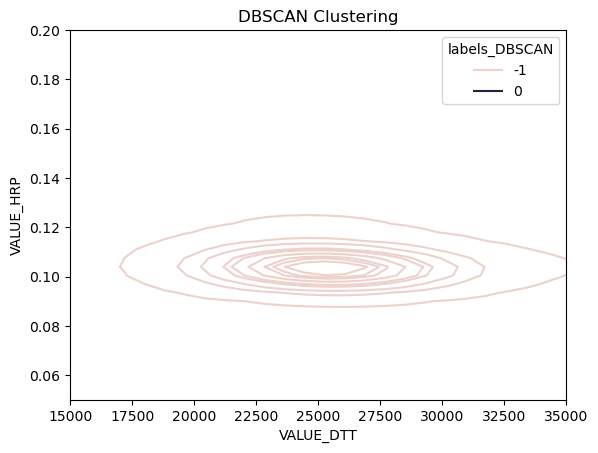

In [18]:
for algorithm in CLUSTERING_CONFIG:
    sns.kdeplot(db_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{algorithm}")
    plt.xlim(15_000, 35_000)
    plt.ylim(0.05, 0.2)
    plt.title(f"{algorithm} Clustering")
    plt.show()